Business Goal 6: We will identify the average persona of a Glossier customer to have a comprehensive understanding of our customer base.

In [0]:
pip install nltk

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
#import the glossier comment dataset 
glos_comm = spark.read.parquet("/FileStore/glossier/glossier_comments")
#import the competitor comment data set 
competitor_comments = spark.read.parquet("dbfs:/FileStore/glossier/competitor_comments")
#import the google trends data set 

In [0]:
#Data cleaning 
#import libraries
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import udf, col, lower, regexp_replace, translate
import re 
#preliminary data cleaning in order to join appropriate colunms 
#Glossier 
#we know all we are interested author, body and the score
glos_comm2 = glos_comm.select("author","body","score")
#filter out any author that says deleted 
glos_comm3 = glos_comm2.filter(glos_comm2.author != "[deleted]")
glos_comm4 = glos_comm3.withColumn("body",lower(translate('body', '!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~', ' ')))
glos_comm4.show(5)
#Now we can move on to doing actual sentiment analysis 

+------------------+--------------------+-----+
|            author|                body|score|
+------------------+--------------------+-----+
|     Aurorabora700|i just got an ema...|    1|
|     beans_sprouts|milk kush is also...|    0|
|            ughkoh|hi all  if you’d ...|    1|
|Altruistic_Bit1657|glossier balm dot...|    1|
|     AutoModerator|\nwelcome to rglo...|    1|
+------------------+--------------------+-----+
only showing top 5 rows



In [0]:
#Now create the nlp pipeline
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

sentimentdl = SentimentDLModel.pretrained(name='sentimentdl_use_twitter', lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [0]:
# running the pipeline
from pyspark.sql.functions import col

empty_df = spark.createDataFrame([['']]).toDF("text")
pipelineModel = nlpPipeline.fit(empty_df)

data = glos_comm4.select(col("body").alias("text"))
result= pipelineModel.transform(data)

In [0]:
import pyspark.sql.functions as F
result = result.select('text', F.explode('sentiment.result').alias("sentiment"))
result.show(5)

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|i just got an ema...| negative|
|milk kush is also...| positive|
|hi all  if you’d ...| positive|
|glossier balm dot...| negative|
|\nwelcome to rglo...| positive|
+--------------------+---------+
only showing top 5 rows



In [0]:
#Now we need to join the gloss_com4 data set with our result 
#we are going to join on body 
#so reamke column in result 
result.createOrReplaceTempView("result_vw")
glos_comm4.createOrReplaceTempView("glossier_vw")
glossier_final= spark.sql("select glossier_vw.*, result_vw.sentiment \
                    from glossier_vw join result_vw on glossier_vw.body = result_vw.text")
glossier_final.show()



+--------------------+--------------------+-----+---------+
|              author|                body|score|sentiment|
+--------------------+--------------------+-----+---------+
|   421_A_Minute_Late|\n\nface   \nhour...|    2| positive|
|           LeahByrne|\n\nface urban de...|    2| positive|
|            CrisCarr|\n\nthanks for th...|    1| negative|
|        beepboop2005|\n garnier micell...|    3|  neutral|
|   HonestThoreauAway|\ndaniel sandler ...|    4| positive|
|   421_A_Minute_Late|\nface\n\nvdl lum...|    3| positive|
|      irregular-moon|\nfave\ni’m a ded...|    7| negative|
|     BrokenRecordBot|\nhere are the di...|    6| negative|
|          Glossyluce|\nhi everyone  i ...|   21| negative|
|   HonestThoreauAway|\ni always imagin...|    2| negative|
|        pinklambchop|\nin broad terms ...|    1| positive|
|         pastapups88|\ni’m 33 so idk i...|    1| negative|
|    sunshineandcacti|\ni’m willing to ...|   13| negative|
|          Meli-llama|\noctober was sur.

In [0]:
#Now I am going to make the sentiment into a dummy variables 
#2= positive 
#1= neutral 
#0=negative
glossier_final2=glossier_final.na.replace("negative","0")
glossier_final3=glossier_final2.na.replace("neutral","1")
glossier_final4=glossier_final3.na.replace("positive","2")
#change sentiment type to integer
glossier_final5=glossier_final4.withColumn("sentiment",col("sentiment").cast("int"))
glossier_final5.show()

+-----------------+--------------------+-----+---------+
|           author|                body|score|sentiment|
+-----------------+--------------------+-----+---------+
|     beepboop2005|\n garnier micell...|    3|        1|
|HonestThoreauAway|\ndaniel sandler ...|    4|        2|
|   spamhunter_bot|\nthis post has b...|    1|        0|
|         celebwen|\r\n\nfinished of...|    1|        2|
|  crystalsandmeth|  aw i was hoping...|    2|        2|
|   lilyalexandra1| byredo bal dafri...|    6|        2|
|       utm_medium| first off both l...|   50|        1|
|   kneecapcabbage| glossier you\n a...|    5|        2|
|       Indigo_222| i have the exact...|    3|        2|
|          pendlea| i think people g...|   14|        1|
|        angiexbby| iso  shipping to...|    2|        2|
|lipsticknleggings| jane iredale spi...|    3|        2|
|     shimmerblitz| molecule 01  iri...|    3|        2|
|         pikachen| murad invisiblur...|    7|        0|
|          boiluna| pink hoodie

In [0]:
from pyspark.sql import functions as F
#Okay no we need to aggreagte by user 
#for score and sentiment we want an average 
#for author we want a count of hoe many times they appear in the data set 
#count("body").as("number_of_posts")
glossier_final6=glossier_final5.groupBy("author").agg({'body':'count', 'score':'avg', 'sentiment':'avg'})
glossier_final7=glossier_final6.withColumnRenamed("avg(score)","average_score")
glossier_final8=glossier_final7.withColumnRenamed("avg(sentiment)","average_sentiment")
glossier_final9=glossier_final8.withColumnRenamed("count(body)","number_of_comments")
glossier_final9.createOrReplaceTempView("glossier_test_vw")
x = spark.sql("select max(number_of_comments) from glossier_test_vw")
#x.show(5)
#53255514
#this is clearly an outlier so I am going to delete it 
glossier_final10 = glossier_final9.filter(glossier_final9.number_of_comments != 53255514)
#check that the outliers are gone
#glossier_final10.sort(col("number_of_comments").desc()).show()
glossier_final10.show()
#Make glossier pandas 

+--------------------+------------------+------------------+------------------+
|              author|     average_score| average_sentiment|number_of_comments|
+--------------------+------------------+------------------+------------------+
|grungebob_scarepants|               2.2|               2.0|                 5|
|             emi_lgr|               4.5|               1.5|                 4|
|       _venetian_red| 6.428571428571429|1.4285714285714286|                14|
|       Glass-Ad-6548|               0.7|               1.0|                10|
|            rebeqa21|1.7826086956521738|0.9565217391304348|                23|
|              kwm608|11.405405405405405|1.5405405405405406|                37|
|      redditgirl2000|11.884615384615385|1.3461538461538463|                26|
|     anonymous_24601|               2.0|               0.0|                 1|
|          Classic500|3.2922535211267605|1.9401408450704225|               284|
|        supertaquito|              1.25

In [0]:
#Now we have to do the same process on the competitors comments ! 
#A lot of this code is taken from Q4_final (1)
#As a result I have already checked for null values ect 
competitor_list = ["Makeup", "MakeupAddiction"]
competitor_comments2 = competitor_comments.filter(competitor_comments.subreddit.isin(competitor_list))
competitor_comments3=competitor_comments2.select("author","body","score")
competitor_comments3 = competitor_comments3.filter(competitor_comments3.author != "[deleted]")
#now we need to filter based on Sephora, Ulta, Fenty and Glossier
from pyspark.sql.functions import col
 
competitor_comments4=competitor_comments3.withColumn("Sephora",col("body").rlike("Sephora|sephora"))
competitor_comments5=competitor_comments4.withColumn("Ulta",col("body").rlike("Ulta|ulta"))
competitor_comments6=competitor_comments5.withColumn("Fenty",col("body").rlike("Fenty|fenty"))
competitor_comments7=competitor_comments6.withColumn("Glossier",col("body").rlike("Glossier|glossier"))

In [0]:
#Now we need to fiter based on whether is says true 
competitor_comments_Sephora=competitor_comments7.filter("Sephora==True")
#Now lets replace the True with Sephora 
competitor_comments_Sephora2=competitor_comments_Sephora.withColumn("Sephora",col("Sephora").cast("string"))
competitor_comments_Sephora3=competitor_comments_Sephora2.na.replace("true","Sephora")
competitor_comments_Sephora4=competitor_comments_Sephora3.select("author","body","score","Sephora")
competitor_comments_Sephora4.show(20)
competitor_comments_Ulta=competitor_comments7.filter("Ulta==True")
competitor_comments_Ulta2=competitor_comments_Ulta.withColumn("Ulta",col("Ulta").cast("string"))
competitor_comments_Ulta3=competitor_comments_Ulta2.na.replace("true","Ulta")
competitor_comments_Ulta4=competitor_comments_Ulta3.select("author","body","score","Ulta")
competitor_comments_Ulta4.show(20)
competitor_comments_Fenty=competitor_comments7.filter("Fenty==True")
competitor_comments_Fenty2=competitor_comments_Fenty.withColumn("Fenty",col("Fenty").cast("string"))
competitor_comments_Fenty3=competitor_comments_Fenty2.na.replace("true","Fenty")
competitor_comments_Fenty4=competitor_comments_Fenty3.select("author","body","score","Fenty")
competitor_comments_Fenty4.show(20)
competitor_comments_Glossier=competitor_comments7.filter("Glossier==True")
competitor_comments_Glossier2=competitor_comments_Glossier.withColumn("Fenty",col("Fenty").cast("string"))
competitor_comments_Glossier3=competitor_comments_Glossier2.na.replace("true","Glossier")
competitor_comments_Glossier4=competitor_comments_Glossier3.select("author","body","score","Fenty")
competitor_comments_Glossier4.show(20)

+--------------------+--------------------+-----+-------+
|              author|                body|score|Sephora|
+--------------------+--------------------+-----+-------+
|   ChesapeakeCowgirl|Honestly that’s w...|    2|Sephora|
| Interesting-Bid-196|My advice is to g...|    1|Sephora|
|Virtual-Magician2384|I'm not an expert...|    1|Sephora|
|        LuluSiberias|Hey that's incred...|   -1|Sephora|
|   dadsgoingtoprison|Tell them you pur...|    3|Sephora|
|        LuluSiberias|I can't help but ...|    1|Sephora|
|        LuluSiberias|I'm really sad th...|    4|Sephora|
|TheoryHistorical2148|Sephora brand is ...|    1|Sephora|
|          Any_Ad3793|Buy Freck! It’s u...|    1|Sephora|
|      truetonebeauty|[Auric Glow Lust ...|    1|Sephora|
|       bakemypeehole|I’ve used this: h...|    1|Sephora|
|      caitlincatelyn|I know ☹️ unfortu...|    4|Sephora|
|  Ok-Perception-5667|40s. Everything b...|    2|Sephora|
|          catsby1970|I can’t speak to ...|    2|Sephora|
|       _blue_

In [0]:
#Okay now I need to stack these dataframes 
#let me rename the colums so they all match 
competitor_comments_Sephora5=competitor_comments_Sephora4.withColumnRenamed("Sephora","Brand")
competitor_comments_Ulta5=competitor_comments_Ulta4.withColumnRenamed("Ulta","Brand")
competitor_comments_Fenty5=competitor_comments_Fenty4.withColumnRenamed("Fenty","Brand")
competitor_comments_Glossier5=competitor_comments_Glossier4.withColumnRenamed("Glossier","Brand")
#Now I need to stack the dataframes 
competitor_temp= competitor_comments_Sephora5.union(competitor_comments_Ulta5)
#competitor_temp.count()
competitor_temp2= competitor_temp.union(competitor_comments_Fenty5)
#one more thing change timestamp and make eveythign in the body lower 
#competitor_temp2.count()
competitor_temp3= competitor_temp2.union(competitor_comments_Glossier5)
competitor_temp4= competitor_temp3.withColumn("body",lower(translate('body', '!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~', ' ')))
#competitor_temp4.count()
competitor_temp4.show(5)

+--------------------+--------------------+-----+-------+
|              author|                body|score|  Brand|
+--------------------+--------------------+-----+-------+
|   ChesapeakeCowgirl|honestly that’s w...|    2|Sephora|
| Interesting-Bid-196|my advice is to g...|    1|Sephora|
|Virtual-Magician2384|im not an expert ...|    1|Sephora|
|        LuluSiberias|hey thats incredi...|   -1|Sephora|
|   dadsgoingtoprison|tell them you pur...|    3|Sephora|
+--------------------+--------------------+-----+-------+
only showing top 5 rows



In [0]:
#Now we can run the sentiment model 
#Now create the nlp pipeline
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

sentimentdl = SentimentDLModel.pretrained(name='sentimentdl_use_twitter', lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [0]:
# running the pipeline
from pyspark.sql.functions import col

empty_df = spark.createDataFrame([['']]).toDF("text")
pipelineModel = nlpPipeline.fit(empty_df)

data = competitor_temp4.select(col("body").alias("text"))
result= pipelineModel.transform(data)

In [0]:
import pyspark.sql.functions as F
result = result.select('text', F.explode('sentiment.result').alias("sentiment"))
result.show(5)

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|honestly that’s w...| negative|
|my advice is to g...| positive|
|im not an expert ...| positive|
|hey thats incredi...| positive|
|tell them you pur...| positive|
+--------------------+---------+
only showing top 5 rows



In [0]:
#Now we need to join the gloss_com4 data set with our result 
#we are going to join on body 
#so reamke column in result 
result.createOrReplaceTempView("result_vw")
competitor_temp4.createOrReplaceTempView("competitor_vw")
competitor_final= spark.sql("select competitor_vw.*, result_vw.sentiment \
                    from competitor_vw join result_vw on competitor_vw.body = result_vw.text")
competitor_final.show()

+--------------------+--------------------+-----+-------+---------+
|              author|                body|score|  Brand|sentiment|
+--------------------+--------------------+-----+-------+---------+
|         gentle-seal|for long term mis...|    2|Sephora| positive|
|      candy_symphony|base colourpop no...|   10|Sephora| positive|
|             KPSTL33|correct me if im ...|    4|   Ulta| positive|
|             KPSTL33|correct me if im ...|    4|Sephora| positive|
|         tempghost11|thanks i’ve been ...|    1|Sephora| positive|
|      mac_peraltiago|alamar cosmetics’...|    3|Sephora| positive|
| L0n3l13sts0ckm0nk3y|try a sample at s...|    1|Sephora| positive|
|    melissajackson07|✴ top 5 favorites...|    1|  false| negative|
|    melissajackson07|✴ top 5 favorites...|    1|Sephora| negative|
|      eyeshadowmania|try looking up so...|    1|Sephora| positive|
|            Hey_Suga|you are the consu...|    1|   Ulta| positive|
|            Hey_Suga|you are the consu...|    1

In [0]:
#Now I am going to make the sentiment into a dummy variables 
#2= positive 
#1= neutral 
#0=negative
competitor_final2=competitor_final.na.replace("negative","0")
competitor_final3=competitor_final2.na.replace("neutral","1")
competitor_final4=competitor_final3.na.replace("positive","2")
#change sentiment type to integer
competitor_final5=competitor_final4.withColumn("sentiment",col("sentiment").cast("int"))
competitor_final5.show()

+--------------------+--------------------+-----+-------+---------+
|              author|                body|score|  Brand|sentiment|
+--------------------+--------------------+-----+-------+---------+
|         gentle-seal|for long term mis...|    2|Sephora|        2|
|      candy_symphony|base colourpop no...|   10|Sephora|        2|
|             KPSTL33|correct me if im ...|    4|   Ulta|        2|
|             KPSTL33|correct me if im ...|    4|Sephora|        2|
|         tempghost11|thanks i’ve been ...|    1|Sephora|        2|
|      mac_peraltiago|alamar cosmetics’...|    3|Sephora|        2|
| L0n3l13sts0ckm0nk3y|try a sample at s...|    1|Sephora|        2|
|    melissajackson07|✴ top 5 favorites...|    1|  false|        0|
|    melissajackson07|✴ top 5 favorites...|    1|Sephora|        0|
|      eyeshadowmania|try looking up so...|    1|Sephora|        2|
|            Hey_Suga|you are the consu...|    1|   Ulta|        2|
|            Hey_Suga|you are the consu...|    1

In [0]:
#Okay now we need to make 3 small data frames for each brand 
#Okay now I need to aggregate by day but since I also have brand I need to take that into account
#filter by brand first 
c_Sephora=competitor_final5.filter("Brand=='Sephora'")
c_Ulta=competitor_final5.filter("Brand=='Ulta'")
c_Fenty=competitor_final5.filter("Brand=='Fenty'")
c_Glossier=competitor_final5.filter("Brand=='Glossier'")

In [0]:
from pyspark.sql import functions as F
#Okay no we need to aggreagte by user 
#for score and sentiment we want an average 
#for author we want a count of hoe many times they appear in the data set 
#count("body").as("number_of_posts")
c_Sephora2=c_Sephora.groupBy("author").agg({'body':'count', 'score':'avg', 'sentiment':'avg'})
c_Sephora3=c_Sephora2.withColumnRenamed("avg(score)","average_score")
c_Sephora4=c_Sephora3.withColumnRenamed("avg(sentiment)","average_sentiment")
c_Sephora5=c_Sephora4.withColumnRenamed("count(body)","number_of_comments")
c_Sephora6=c_Sephora5.select(F.avg('average_score'), F.avg('average_sentiment'), F.avg('number_of_comments'))
#Make glossier pandas 
c_Sephora7= c_Sephora6.toPandas()
c_Sephora7



,avg(average_score),avg(average_sentiment),avg(number_of_comments)
0,5.67927,1.313598,1.994646


In [0]:
c_Ulta2=c_Ulta.groupBy("author").agg({'body':'count', 'score':'avg', 'sentiment':'avg'})
c_Ulta3=c_Ulta2.withColumnRenamed("avg(score)","average_score")
c_Ulta4=c_Ulta3.withColumnRenamed("avg(sentiment)","average_sentiment")
c_Ulta5=c_Ulta4.withColumnRenamed("count(body)","number_of_comments")
c_Ulta6=c_Ulta5.select(F.avg('average_score'), F.avg('average_sentiment'), F.avg('number_of_comments'))
#Make glossier pandas 
c_Ulta7= c_Ulta6.toPandas()
c_Ulta7


,avg(average_score),avg(average_sentiment),avg(number_of_comments)
0,5.494351,1.401223,1.892262


In [0]:
c_Fenty2=c_Fenty.groupBy("author").agg({'body':'count', 'score':'avg', 'sentiment':'avg'})
c_Fenty3=c_Fenty2.withColumnRenamed("avg(score)","average_score")
c_Fenty4=c_Fenty3.withColumnRenamed("avg(sentiment)","average_sentiment")
c_Fenty5=c_Fenty4.withColumnRenamed("count(body)","number_of_comments")
c_Fenty6=c_Fenty5.select(F.avg('average_score'), F.avg('average_sentiment'), F.avg('number_of_comments'))
#Make glossier pandas 
c_Fenty7= c_Fenty6.toPandas()
c_Fenty7

,avg(average_score),avg(average_sentiment),avg(number_of_comments)
0,4.533575,1.57344,2.228101


In [0]:
c_Glossier2=c_Glossier.groupBy("author").agg({'body':'count', 'score':'avg', 'sentiment':'avg'})
c_Glossier3=c_Glossier2.withColumnRenamed("avg(score)","average_score")
c_Glossier4=c_Glossier3.withColumnRenamed("avg(sentiment)","average_sentiment")
c_Glossier5=c_Glossier4.withColumnRenamed("count(body)","number_of_comments")
c_Glossier6=c_Glossier5.select(F.avg('average_score'), F.avg('average_sentiment'), F.avg('number_of_comments'))
#Make glossier pandas 
c_Glossier7= c_Glossier6.toPandas()
c_Glossier7

,avg(average_score),avg(average_sentiment),avg(number_of_comments)
0,7.638916,1.677141,3.244792


In [0]:
import pandas as pd
#Now we need to make this into one data frame 
#glossier_final12
#c_Fenty7
#c_Ulta7
#c_Sephora7
final_df_all=pd.concat([c_Glossier7, c_Fenty7, c_Ulta7, c_Sephora7], ignore_index=True, axis=0)
#final_df_all
#now add brand names 
brands = ['Glossier', 'Fenty', 'Ulta', 'Sephora']
  
# Using 'Address' as the column name
# and equating it to the list
final_df_all['brands'] = brands 
final_df_all.rename({'avg(average_score)': 'average_score', 'avg(average_sentiment)': 'average_sentiment', 'avg(number_of_comments)': 'number_of_comments' }, axis=1, inplace=True)
final_df_all
display(final_df_all)

average_score,average_sentiment,number_of_comments,brands
7.638916320947572,1.6771412037037037,3.2447916666666665,Glossier
4.53357536585547,1.5734402764246387,2.228100607111882,Fenty
5.49435138188805,1.4012229953355102,1.8922617566558846,Ulta
5.67927040207684,1.3135979458198535,1.9946460440214158,Sephora


In [0]:
## Melt the dataframe for plotting purposes 
final_df_all_viz = final_df_all
final_df_all_viz = pd.melt(final_df_all_viz, id_vars=['brands'], value_vars=['average_score', 'average_sentiment','number_of_comments'])
final_df_all_viz = final_df_all_viz.rename({'brands': 'brand', 'variable': 'metric', 'value': 'score'}, axis=1)
final_df_all_viz.head(5)

,brand,metric,score
0,Glossier,average_score,7.638916
1,Fenty,average_score,4.533575
2,Ulta,average_score,5.494351
3,Sephora,average_score,5.679270
4,Glossier,average_sentiment,1.677141


/databricks/python/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
Out[53]: Text(0.5, 0.98, 'Average User Persona Across Metrics By Brand')

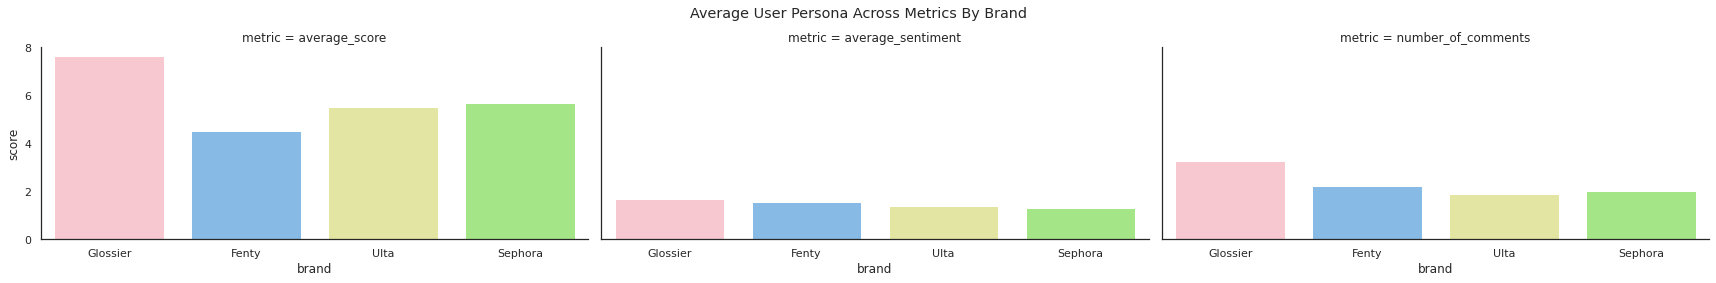

In [0]:
## Plot the results on a static chart
import matplotlib.pyplot as plt
import seaborn as sns
clrs = ["#FFC0CB", "#78BCF4","#EDF197", "#9EF478"]
sns.set(font_scale=3, rc={'figure.figsize':(20,10)})
sns.set_theme(style='white')
g = sns.FacetGrid(final_df_all_viz, col="metric",
                  palette=clrs, height=4, aspect=2)
g.map(sns.barplot, 'brand', 'score',palette=clrs)
g.fig.subplots_adjust(top=0.84)
g.fig.suptitle('Average User Persona Across Metrics By Brand')

In [0]:
## Plot the interactive chart 
import plotly.express as px
import os
fig = px.bar(final_df_all_viz, x="brand", y="score", facet_col="metric",
            title = "Average User Persona Across Metrics By Brand", color = "brand",
            color_discrete_sequence=["#FFC0CB", "#78BCF4","#EDF197", "#9EF478"])

fig.update_layout(plot_bgcolor = "white",  yaxis_title="score", title_x=0.5,
                 xaxis={'categoryorder':'total descending'})
fpath = os.path.join("/Workspace/Repos/cag199@georgetown.edu/fall-2022-reddit-big-data-project-project-group-16/data/plots/NLP/", "avg_persona_viz.html")
fig.write_html(fpath)
fig.show()
